<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/lindevanbeers/Lab-3/linde-report-lab-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab X: Title**
**Johan Hoffman**

# **Abstract**



```
# This is formatted as code
```

Short summary of the lab report. State the objectives, methods used, main results and conlusions. 

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [1]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

Give a short description of the problem investigated in the report, and provide some background information so that the reader can understand the context. 

Briefly describe what method you have chosen to solve the problem, and justify why you selected that method. 

Here you can express mathematics through Latex syntax, and use hyperlinks for references.

[Hyperlink to DD2363 course website.](https://kth.instructure.com/courses/7500)

$
{\displaystyle \frac{\partial u}{\partial t}} + u\cdot \nabla u +\nabla p = f, \quad \nabla \cdot u=0$



# **Methods**

Describe the methods you used to solve the problem. This may be a combination of text, mathematical formulas (Latex), algorithms (code), data and output.  

### Jacobi Iteration for Ax=b

This algorithm takes as input nxn matrix A, and vector b of length n, and a floating number tol.

The output is an approximation of vector x such that Ax = b. The accuracy is such that $||b-Ax|| \leq tol$. 

Test: convergence of residual || Ax-b ||, || x-y || for manufactured/exact solution y 

In [0]:
def jacobi_iter(A, b, tol):
  # Initialization
  n = A.shape[0]
  x = np.zeros([n,])
  r = b - np.matmul(A,x)
  rs = np.array([np.linalg.norm(r)])
  k = 0
  xnew = x.copy()
  # Jacobi iteration algorithm
  while np.linalg.norm(r) > tol:
    for i in range(n):
      sum = 0
      for j in range(n):
        if j != i:
          sum = sum + (A[i,j]*x[j])
      xnew[i] = (1/A[i,i]) * (b[i] - sum)
    x = xnew.copy()
    r = b - np.matmul(A,x)
    rs = np.append(rs, np.linalg.norm(r))
    k += 1  
  # Covergence visualisation
  fig = plt.figure()
  rPlt = fig.add_subplot(111)
  rPlt.plot(rs, np.array(range(k+1)))
  return x

def converge_criterion(A):
  n = A.shape[0]
  I = np.eye(n)
  Dinv = np.multiply(1/A,I)
  M = I - np.matmul(Dinv,A)
  eigvals = np.linalg.eigvals(M)
  max = 0
  for i in range(len(eigvals)):
    if eigvals[i] > max:
      max = eigvals[i]
  if max < 1:
    return True
  else:
    return False

### Gauss-Seidel Iteration for Ax=b

Input: matrix A, vector b

Output: vector x

Test: convergence of residual || Ax-b ||, || x-y || for manufactured/exact solution y

### Newton's method for scalar nonlinear equation f(x)=*0*

Input: scalar function f(x)

Output: real number x

Test: convergence of residual |f(x)|, |x-y| for manufactured/exact solution y

# **Results**

Present the results. If the result is an algorithm that you have described under the *Methods* section, you can present the data from verification and performance tests in this section. If the result is the output from a computational experiment this is where you present a selection of that data. 

### Jacobi Iteration for *Ax=b*


Test 1
A: [[20  1 -2]
 [ 3 20 -1]
 [ 2 -3 20]]
b: [ 17 -18  25]
x: [ 0.9999995  -0.99999713  0.99999175]
Ax: [[ 17.00000938 -17.99993575  24.99982537]]

Test 2
A: [[20  1 -2]
 [ 3 20 -1]
 [ 2 -3 20]]
y: [ 17 -18  25]
b: [ 272 -334  588]
x: [ 16.99997933 -18.00001014  25.0000087 ]
Ax: [[ 271.99955896 -334.00027347  588.00016306]]

Test 3
A: [[1 2 3]
 [4 5 6]
 [7 8 9]]
b: [1 2 3]
Convergence criterion was not met


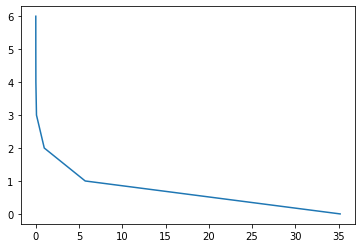

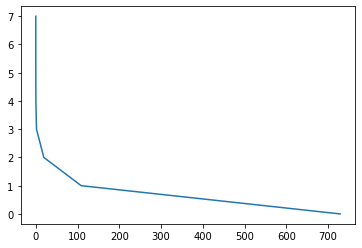

In [98]:
tol = 0.001

print("Test 1")
A = np.matrix([[20,1,-2],[3,20,-1],[2,-3,20]])
b = np.array([17,-18,25])
print("A:", A)
print("b:", b)
if converge_criterion(A):
  x = jacobi_iter(A,b,tol)
  print("x:", x)
  print("Ax:",np.matmul(A,x))
else:
  print("Convergence criterion was not met")

print("\nTest 2")
A = np.matrix([[20,1,-2],[3,20,-1],[2,-3,20]])
y = np.array([17,-18,25])
b = np.array(np.matmul(A,y))[0]
print("A:", A)
print("y:", y)
print("b:", b)
if converge_criterion(A):
  x = jacobi_iter(A,b,tol)
  print("x:", x)
  print("Ax:",np.matmul(A,x))
else:
  print("Convergence criterion was not met")

print("\nTest 3")
A = np.matrix([[1,2,3],[4,5,6],[7,8,9]])
b = np.array([1,2,3])
#b = np.array(np.matmul(A,y))[0]
print("A:", A)
print("b:", b)
if converge_criterion(A):
  x = jacobi_iter(A,b,tol)
  print("x:", x)
  print("Ax:",np.matmul(A,x))
else:
  print("Convergence criterion was not met")

### Gauss-Seidel Iteration for *Ax=b*

### Newton's method for scalar nonlinear equation *f(x)=0*


# **Discussion**

Summarize your results and your conclusions. Were the results expected or surprising. Do your results have implications outside the particular problem investigated in this report? 

# **APPENDIX**

In this appendix some examples are given to express and visualizing mathematical concepts such as vectors, matrices, meshes and functions. 

This is not part of the template report for the course.

# **Vector**

In this cell some basic commands are introduced for how to define and process a vector, where the NumPy array data type is used. 

In [0]:
# Just a test
# Create a vector as a NumPy array
x = np.array([1,2,3,4])

# Print various attributes of the vector
print('x =',x)
print('x[2] =',x[2])
print('x[0:2] =',x[0:2])
print('x.shape =',x.shape)
print('x.ndim =',x.ndim)
print('x.size =',x.size)
print('x.dtype =',x.dtype)

# Print the elements of vector x
for i in range(x.size):
  print("x[",i,"] =",x[i])

# Assign a float value to the int vector x
x[1] = 2.1
print('x =',x)

# Copy the int vector x to a float vector xf
xf = x.astype(float)
xf[1] = 2.1
print('xf =',xf)
print('xf.dtype =',xf.dtype)

# Create a complex vector 
y = np.array([2,3,4], dtype=complex)
print('y =',y)
print('y.dtype =',y.dtype)

# Create a vector z by defining a range through an increment
z = np.arange(12, 28, 4.5)
print('z =',z)

# Overwrite the vector z by a vector of uniformly spaced elements in a range
pi=np.pi
pi
z = np.linspace(0, 2*pi, 5)
print('z =',z)

# Visualize the vector in a plot. 
plt.figure()
plt.plot(x,2*x,'ro-')
plt.show()

# **Matrix**

In this cell some basic commands for defining and processing a matrix
is introduced, where we use the NumPy array data type. 

In [0]:
# Define a matrix as a NumPy array
A = np.array([[2,4,6], [3,6,9], [1,2,1]])

# Print various attributes of the matrix 
print('A =',A)
print('A[1,0] =',A[1,0])
print('A.shape =',A.shape)
print('A.ndim =',A.ndim)
print('A.size =',A.size)

# Plot the matrix
plt.figure()
plt.plot(A,'o-')

# Construct a simple sparse matrix class using the CRS data structure
class spMatrix:
  def __init__(self, val, col_idx, row_ptr):
    self.val = val
    self.col_idx = col_idx
    self.row_ptr = row_ptr
    
# Create a sparse matrix object 
val = np.array([3, 2, 2, 2, 1, 1, 3, 2, 1, 2, 3])
col_idx = np.array([1, 2, 4, 2, 3, 3, 3, 4, 5, 5, 6])
row_ptr = np.array([1, 4, 6, 7, 9, 10])
spA = spMatrix(val, col_idx, row_ptr)

# Print sparse matrix object attributes
print('Sparse matrix values: \n',spA.val)
print('Sparse matrix column indices: \n',spA.col_idx)
print('Sparse matrix row pointer: \n',spA.row_ptr)
    

# **Function**

In this cell we illustrate how functions are defined. 

In [0]:
# Define a function f(x,y)
def f(x,y):
  return x + y 

# Verify the function output
print('f(3,4) =',f(3,4))

# Define a function of a function
def g1(fcn,arg1,arg2):
  z = fcn(arg1,arg2)
  print('z =',z)

# Call the function
g1(f,6,7)

# Define a function of a function with arguments in a list or array
def g2(fcn,arg):
  z = fcn(*arg)
  print('z =',z)
  
# Call the function with arguments as list and array
xlist = [8,9]
xarray = np.array([11,3])
g2(f,xlist)
g2(f,xarray)

# Define a function to format the print out for a matrix 
def printMatrix(A):
   rows = A.shape[0]
   cols = A.shape[1]
   for i in range(0,rows):
      for j in range(0,cols):
         print(A[i,j]," ", end='')
      print()

# Define matrix      
A = np.array([[1,2,3], [4,5,6], [7,8,9]])

# Verify the function output
print('A =', A)
print('A =')
printMatrix(A)
print('A^T =')
printMatrix(A.transpose())

# Plot a Euclidian position vector v 
def plotEVector(vec):
  plt.figure()
  plt.xlim([-1.5*vec[0], 1.5*vec[0]])
  plt.ylim([-1.5*vec[1], 1.5*vec[1]])
  plt.quiver(0, 0, vec[0], vec[1], scale=1, scale_units='xy', angles='xy')
  plt.show()

v = np.array([3,4])
plotEVector(v)




# **Plot**

In [0]:
# Define a range for a parameter t
t = np.arange( 0.0, 10, 0.5)

# Initialize a new figure and set the size 
plt.figure(2)
plt.figure(figsize=(12,6))

# Define a subplot structure and choose the first subplot 
plt.subplot(121)

# Plot a standard NumPy function against the parameter t
plt.plot(t,np.cos(t))

# Set plot labels and title for the subplot
plt.xlabel('x')
plt.ylabel('y')
plt.title('My plot: $y = cos(x)$')

# Choose the other subplot
plt.subplot(122)

# Plot three functions in the same subplot
plt.plot(t, np.sin(f(t,3)), 'g*', t, 0.03*t**2, 'ro', t, 0.1*t, 'b')
plt.axis([-1, 12, -2 ,3])

# Show the figure
plt.show()

# Triangular **mesh**

This cell describes how to generate a triangular mesh from a point cloud by the Delaunay algorithm. It also illustrates how to access the mesh data structures. 

In [0]:
# Start the clock 
start = time.time()

# Generate a point cloud
Nx = 5
Ny = 5
hx = 1.0/(Nx-1)
hy = 1.0/(Ny-1)
x = np.zeros((Nx*Ny))
y = np.zeros((Nx*Ny))
for i in range(Nx):
  for j in range(Ny):
    x[i*Nx + j] = j*hx
    y[i*Nx + j] = i*hy

# Generate a mesh from the point cloud using a Delaunay algorithm
mesh = tri.Triangulation( x, y )

# Stop the clock
end = time.time()

# Print the measured time
print ("Mesh generation took: ", end - start, "seconds (wall-clock time)")

# Print mesh data structure
vertices = np.array([mesh.x, mesh.y])
print('vertices = \n', vertices)
print('edges = \n', mesh.edges)
print('triangles = \n', mesh.triangles)
print('neighbor triangles = \n', mesh.neighbors)

# Plot the mesh 
plt.figure(3)
plt.figure(figsize=(10,10))
plt.triplot(mesh, 'bo-', lw=1)
plt.title('Delaunay mesh')
plt.show()

# Define a function g(x,y)
def g(x,y):
    return np.sin(10*x)*np.cos(3*y)

# Plot the function g(x,y) in a contour plot
plt.figure(4)
plt.tricontour(mesh, g(x,y), cmap=plt.cm.spectral)
plt.show()

# Plot the function g(x,y) in 3D as a surface plot
fig = plt.figure(5)
ax1 = fig.add_subplot(111, projection='3d')
surf = ax1.plot_trisurf(mesh, g(x,y), cmap=plt.cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=10)
ax1.view_init(20,10)
plt.show()

# Parametric **curve**

This cell illustrates how to visualize a parametric curve.

In [0]:
# Define paramter range
t = np.linspace(0, 4*np.pi, 100)

# Define the curve
x = t*np.cos(t)
y = t*np.sin(t)
z = t

fig = plt.figure(6)
ax = fig.gca(projection = '3d')
ax.plot(x, y, z)
plt.title('Parametric curve')
plt.show()